In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"


In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

# Load raw events

In [3]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])
# SM processes

neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, files["leptoquark"])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


# Load embedding model

In [4]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]
output_dim = model_hyper_parameters["output_dim"]

embedding_model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 4}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Embed events

In [5]:
from analysis import inference

In [6]:
from data import EventDataset

In [7]:
infer_test_num = 1000000
bkg_infer_test = bkg[:infer_test_num]
infer_dataset = EventDataset(bkg_infer_test)
infer_dataloader = DataLoader(infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_boson_infer_test = neutral_boson[:infer_test_num]
neutral_boson_infer_dataset = EventDataset(neutral_boson_infer_test)
neutral_boson_infer_dataloader = DataLoader(neutral_boson_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

leptoquark_infer_test = leptoquark[:infer_test_num]
leptoquark_infer_dataset = EventDataset(leptoquark_infer_test)
leptoquark_infer_dataloader = DataLoader(leptoquark_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_Higgs_infer_test = neutral_Higgs[:infer_test_num]
neutral_Higgs_infer_dataset = EventDataset(neutral_Higgs_infer_test)
neutral_Higgs_infer_dataloader = DataLoader(neutral_Higgs_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

charged_Higgs_infer_test = charged_Higgs[:infer_test_num]
charged_Higgs_infer_dataset = EventDataset(charged_Higgs_infer_test)
charged_Higgs_infer_dataloader = DataLoader(charged_Higgs_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

In [8]:
embedding_model.load_state_dict(torch.load(os.path.join("..", "model","emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale))))
embedding_model.to(device)
bkg_embed_points = inference(embedding_model, infer_dataloader, embed_dim=output_dim)
print(bkg_embed_points.shape)

100%|██████████| 3907/3907 [00:08<00:00, 446.30it/s]

(1000000, 4)


In [9]:
neutral_boson_embed_points = inference(embedding_model, neutral_boson_infer_dataloader, embed_dim=output_dim)
leptoquark_embed_points = inference(embedding_model, leptoquark_infer_dataloader, embed_dim=output_dim)
neutral_Higgs_embed_points = inference(embedding_model, neutral_Higgs_infer_dataloader, embed_dim=output_dim)
charged_Higgs_embed_points = inference(embedding_model, charged_Higgs_infer_dataloader, embed_dim=output_dim)
print(neutral_boson_embed_points.shape)
print(leptoquark_embed_points.shape)
print(neutral_Higgs_embed_points.shape)
print(charged_Higgs_embed_points.shape)

100%|██████████| 2970/2970 [00:06<00:00, 446.90it/s]

(55969, 4)
(340544, 4)
(691283, 4)
(760272, 4)


In [10]:
from analysis import Normalizer

In [11]:
import importlib
import analysis
importlib.reload(analysis)
from analysis import Normalizer

In [12]:
normalizer = Normalizer(bkg_embed_points, neutral_boson_embed_points, leptoquark_embed_points, neutral_Higgs_embed_points, charged_Higgs_embed_points)

# Split embed points

In [13]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}

In [14]:
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders

In [15]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 100000

# exp_events, bkg_events = create_exp_bkg_events(bkg_embed_points, neutral_boson_embed_points, sig_lambda, n)
# exp_events, bkg_events = create_exp_bkg_events(bkg_embed_points, leptoquark_embed_points, sig_lambda, n)
# exp_events, bkg_events = create_exp_bkg_events(bkg_embed_points, neutral_Higgs_embed_points, sig_lambda, n)
exp_events, bkg_events = create_exp_bkg_events(bkg_embed_points, charged_Higgs_embed_points, sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

# Classify Model

In [16]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [17]:
from metrics import BinaryACCUpdater

In [18]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [19]:
from classify import train_model

In [20]:
opt_train_model  = torch.compile(train_model)

In [21]:
opt_train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-05-18 21:24:14
Epoch 1 / 50

  0%|          | 0/4000 [00:00<?, ?it/s]

/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:140: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


100%|██████████| 125/125 [00:04<00:00, 28.29it/s, val_Accuracy=0.681, val_loss=0.589]
<<<<<< reach best val_Accuracy : 0.6806562542915344 >>>>>>

================================================================================2024-05-18 21:24:37
Epoch 2 / 50

100%|██████████| 125/125 [00:00<00:00, 630.68it/s, val_Accuracy=0.677, val_loss=0.589]

================================================================================2024-05-18 21:24:44
Epoch 3 / 50

100%|██████████| 125/125 [00:00<00:00, 585.75it/s, val_Accuracy=0.681, val_loss=0.586]

================================================================================2024-05-18 21:24:52
Epoch 4 / 50

100%|██████████| 125/125 [00:00<00:00, 581.24it/s, val_Accuracy=0.681, val_loss=0.586]
<<<<<< reach best val_Accuracy : 0.6806875467300415 >>>>>>

================================================================================2024-05-18 21:25:00
Epoch 5 / 50

100%|██████████| 125/125 [00:00<00:00, 567.69it/s, val_Accuracy=0.679, val_

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.607028,0.660508,0.588944,0.680656,1
1,0.589539,0.678781,0.589455,0.676719,2
2,0.588336,0.678813,0.586267,0.680500,3
3,0.587623,0.679672,0.585847,0.680688,4
4,0.587166,0.678773,0.585847,0.679188,5
5,0.586760,0.678977,0.590350,0.677625,6
6,0.586432,0.679641,0.585250,0.678906,7
7,0.586261,0.680109,0.584787,0.679531,8
8,0.586013,0.679922,0.584211,0.680375,9


# ROC

In [22]:
from analysis import predict

In [23]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 962.79it/s]


0.71805504296875


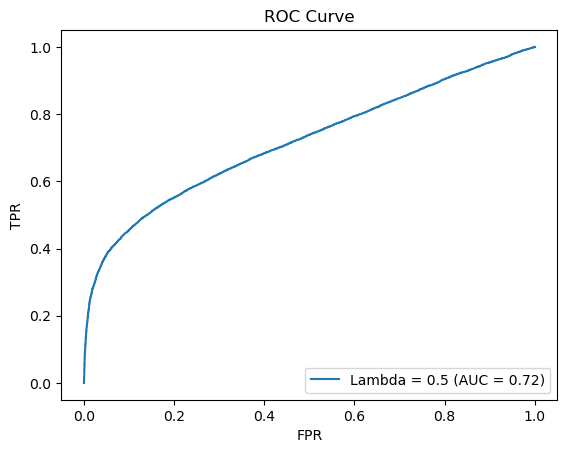

In [24]:
from analysis import calculate_auc
from visualize import plot_roc_curve
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(sig_lambda)] = fpr
tpr_dict[str(sig_lambda)] = tpr
auc_dict[str(sig_lambda)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")

# Test statistics

In [34]:
from analysis import Bootstrap_Permutation

In [38]:
importlib.reload(analysis)
from analysis import Bootstrap_Permutation

In [39]:
bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)

In [40]:
lrt_null_bootstarp, auc_null_bootstarp, mce_null_bootstarp = bootstrap_permutation.bootstrap(10000)

100%|██████████| 10000/10000 [21:44<00:00,  7.66it/s]


In [41]:
lrt_null_permutation, auc_null_permutation, mce_null_permutation = bootstrap_permutation.permutation(10000)

100%|██████████| 10000/10000 [22:54<00:00,  7.27it/s]


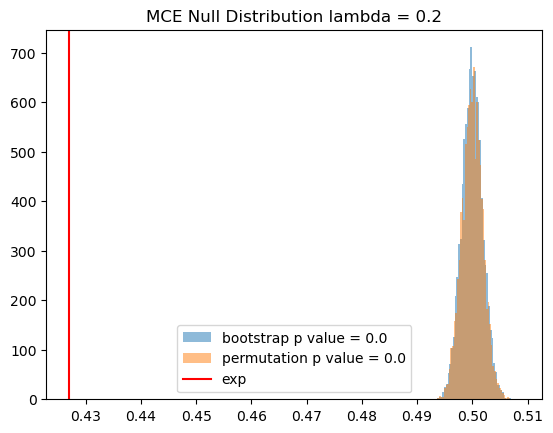

In [42]:
plt.hist(mce_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.mce_p_bootstrap))
plt.hist(mce_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.mce_p_permutation))
plt.axvline(bootstrap_permutation.mce_exp, color='r', label="exp")
plt.legend()
plt.title("MCE Null Distribution lambda = {}".format(sig_lambda))
plt.show()

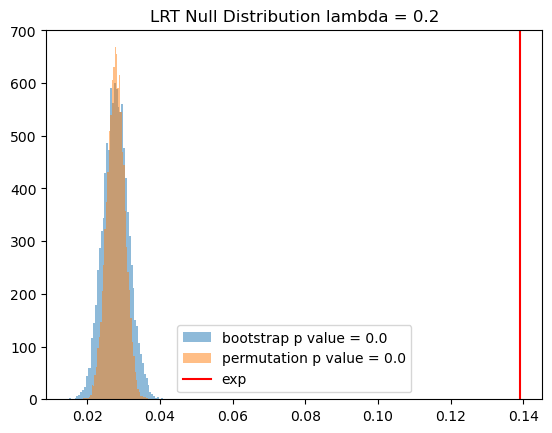

In [43]:
plt.hist(lrt_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.lrt_p_bootstrap))
plt.hist(lrt_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.lrt_p_permutation))
plt.axvline(bootstrap_permutation.lrt_exp, color='r', label="exp")
plt.legend()
plt.title("LRT Null Distribution lambda = {}".format(sig_lambda))
plt.show()

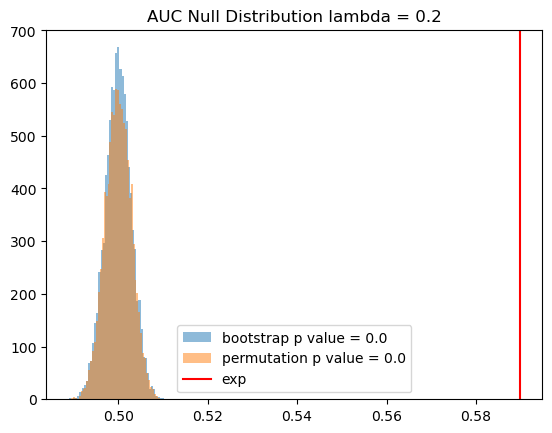

In [44]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.auc_p_bootstrap))
plt.hist(auc_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.auc_p_permutation))
plt.axvline(bootstrap_permutation.auc_exp, color='r', label="exp")
plt.legend()
plt.title("AUC Null Distribution lambda = {}".format(sig_lambda))
plt.show()

# Estimate signal strength

In [25]:
from analysis import LambdaEstimator

estimated lambda: 0.47777884627994394
beta 0 = -0.5286130283182882, beta 1 = -0.12105108637198939
last bin height: 0.5222211537200561


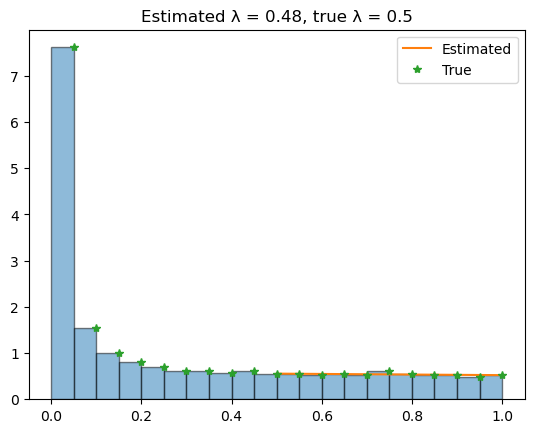

In [26]:
lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
print("estimated lambda:", lambda_estimator.estimated_lambda)
print("beta 0 = {}, beta 1 = {}".format(lambda_estimator.beta0, lambda_estimator.beta1))
print("last bin height:", lambda_estimator.estimated_H_t[-1])
plt.hist(lambda_estimator.rho_W, bins=lambda_estimator.bins, alpha=0.5, edgecolor='black', density=True)
start_idx = lambda_estimator.fit_start_idx
plt.plot(lambda_estimator.bins[start_idx:], lambda_estimator.estimated_H_t, label="Estimated")
plt.plot(lambda_estimator.bins[1:], lambda_estimator.H_t, '*',label="True")
plt.legend()
plt.title("Estimated λ = {:.2f}, true λ = {}".format(lambda_estimator.estimated_lambda, sig_lambda))
plt.show()

# Bootstrapped Uncertainty Intervals for λ

In [27]:
lambda_mean_dict = {}
lambda_std_dict = {}

In [36]:
import importlib
import classify
importlib.reload(classify)
from classify import train_model
opt_train_model  = torch.compile(train_model)

In [62]:
n_bootstrap = 10


test_ratio=0.2
val_ratio = 0.2
n = 100000
sig_lambda = 0.7
estimated_lambdas = np.zeros(n_bootstrap)
for j in range(n_bootstrap):
    exp_events, bkg_events = create_exp_bkg_events(bkg_embed_points, charged_Higgs_embed_points, sig_lambda, n)
    X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
    n1 = len(W1)
    m1 = len(X1)
    n2 = len(W2)
    m2 = len(X2)
    train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCELoss()
    acc_metric = BinaryACCUpdater()
    metric_dict = {"Accuracy": acc_metric}

    opt_train_model(
        naive_model, optimizer,
        loss_fn, metrics_dict=metric_dict,
        train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        monitor="val_Accuracy", mode="max",
        epochs=50,
        verbose=False
        )

    lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
    estimated_lambdas[j] = lambda_estimator.estimated_lambda
print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)



================================================================================2024-05-18 23:31:33
Epoch 1 / 50


================================================================================2024-05-18 23:31:41
Epoch 2 / 50


================================================================================2024-05-18 23:31:50
Epoch 3 / 50


================================================================================2024-05-18 23:31:58
Epoch 4 / 50


================================================================================2024-05-18 23:32:06
Epoch 5 / 50


================================================================================2024-05-18 23:32:14
Epoch 6 / 50


================================================================================2024-05-18 23:32:22
Epoch 7 / 50


================================================================================2024-05-18 23:32:31
Epoch 8 / 50


===============================================================================

In [63]:
print(estimated_lambdas)
print(lambda_mean_dict)
print(lambda_std_dict)

[0.68567765 0.68312086 0.69805316 0.69125528 0.70192344 0.69837244
 0.70103041 0.690725   0.6800671  0.7099664 ]
{'0': 0.0080320690971304, '0.01': 0.019468236225090772, '0.05': 0.038816248780587016, '0.1': 0.09406796436855905, '0.2': 0.1940646770424082, '0.5': 0.49805131490003224, '0.7': 0.694019174554916}
{'0': 0.019326242534985116, '0.01': 0.01274472235771524, '0.05': 0.03575048333691962, '0.1': 0.009044430041588378, '0.2': 0.009297250634290646, '0.5': 0.019882964768834475, '0.7': 0.009443860046643411}


In [64]:
from visualize import plot_lambda

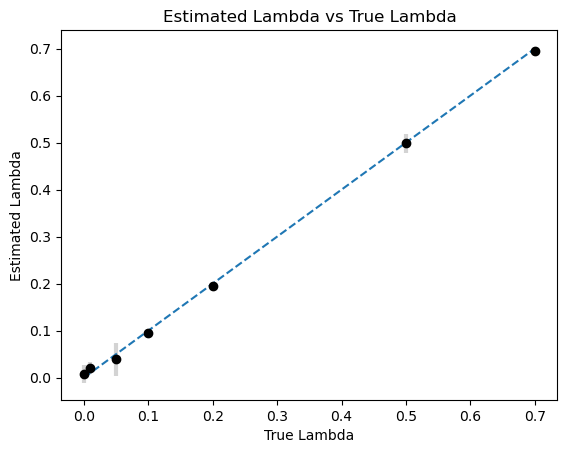

In [65]:
plot_lambda(lambda_mean_dict, lambda_std_dict)